<a href="https://colab.research.google.com/github/gulabpatel/ExplainableAI/blob/main/03%3A%20ML_Shap_Library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Video walkthrough the code : https://www.youtube.com/watch?v=IqT551LjKHw

In [ ]:
!pip install shap

In [2]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [3]:
X, y = shap.datasets.boston()

In [4]:
print(f"Mean value of median house prices (in $ thousand): {round(y.mean(), 2)}")

Mean value of median house prices (in $ thousand): 22.53


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

## Linear Regression

In [6]:
catagorical_features = ['CHAS']
numerical_features = [c for c in X_train.columns if c not in catagorical_features]
cat = [([c], [OrdinalEncoder()]) for c in catagorical_features]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num + cat, df_out=True)
preprocessed_X_train = mapper.fit_transform(X_train)
preprocessed_X_train = sm.add_constant(preprocessed_X_train)
reg = sm.OLS(y_train, preprocessed_X_train).fit()

In [7]:
def evaluate(X, y, mapper=None, reg=None, transform=False):
    if transform:
        X = mapper.transform(X)
        X = sm.add_constant(X, has_constant='add') 
    y_pred = reg.predict(X)
    return mean_absolute_error(y, y_pred)

In [8]:
train_mae = evaluate(X_train, y_train, mapper, reg, True)
test_mae = evaluate(X_test, y_test, mapper, reg, True)
print(f"train MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

train MAE = 3.388, test MAE = 2.52 


In [9]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     97.41
Date:                Tue, 22 Jun 2021   Prob (F-statistic):          1.35e-120
Time:                        07:50:37   Log-Likelihood:                -1361.2
No. Observations:                 455   AIC:                             2750.
Df Residuals:                     441   BIC:                             2808.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.7675      0.240     95.013      0.000      22.297      23.238
CRIM          -0.9544      0.316     -3.021      0.003      -1.575      -0.333
ZN             1.1903      0.347      3.426      0.001       0.508       1.873
INDUS          0.2159      0.445      0.485      0.628      -0.659       1.091
NOX           -2.0944      0.505     -4.148      0.000      -3.087      -1.102
RM             2.7612      0.317      8.700      0.000       2.137       3.385
AGE            0.3042      0.411      0.739      0.460      -0.504       1.113
DIS           -3.1207      0.460     -6.788      0.000      -4.024      -2.217
RAD            2.9649      0.678      4.372      0.000       1.632       4.298
TAX           -2.4522      0.715     -3.430      0.001      -3.857      -1.047
PTRATIO       -2.0042      0.310     -6.468      0.000      -2.613      -1.395
B              0.8742      0.272      3.213      0.001       0.339       1.409
LSTAT         -4.0539      0.394    -10.283      0.000      -4.829      -3.279
CHAS           2.5088      0.895      2.804      0.005       0.750       4.267
==============================================================================
Omnibus:                      152.667   Durbin-Watson:                   1.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              592.005
Skew:                           1.474   Prob(JB):                    2.80e-129
Kurtosis:                       7.747   Cond. No.                         10.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Random Forest 

In [11]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
catagorical_features = ['CHAS']
numerical_features = [c for c in X_train.columns if c not in catagorical_features]
cat = [([c], [OrdinalEncoder()]) for c in catagorical_features]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num + cat, df_out=True)
reg = RandomForestRegressor()
pipeline = Pipeline([
    ('preprocess', mapper),
    ('reg', reg)
])
p = pipeline.fit(X_train, y_train)

train_mae = evaluate(X_train, y_train, reg=pipeline)
test_mae = evaluate(X_test, y_test, reg=pipeline)
print(f"train MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

train MAE = 0.776, test MAE = 2.741 


<BarContainer object of 13 artists>

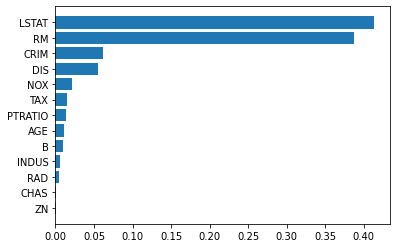

In [12]:
sorted_idx = reg.feature_importances_.argsort()
features = numerical_features + catagorical_features 
result = sorted(zip(features, reg.feature_importances_), key = lambda x: x[1], reverse=False)
plt.barh([x[0] for x in result], [x[1] for x in result])

## Neural Networks

In [13]:
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim

preprocessed_X_train = mapper.fit_transform(X_train)

num_epochs = 50
learning_rate = 0.01
hidden_size = 32
batch_size = 50
input_dim = preprocessed_X_train.shape[1]
batch_no = preprocessed_X_train.shape[0] // batch_size
model = nn.Sequential(
    nn.Linear(input_dim, hidden_size),
    nn.Linear(hidden_size, 1)
)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_batch = Variable(torch.FloatTensor(preprocessed_X_train.values[start:end]))
        y_batch = Variable(torch.FloatTensor(y_train[start:end]))
        optimizer.zero_grad()
        y_preds = model(x_batch)
        loss = criterion(y_preds, torch.unsqueeze(y_batch,dim=1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0: 
        print("Epoch {}, Loss: {}".format(epoch, running_loss))
        
preprocessed_X_test = mapper.transform(X_test)
y_pred = model(torch.from_numpy(preprocessed_X_test.values).float()).flatten().detach().numpy()
test_mae = mean_absolute_error(y_test, y_pred)
preprocessed_X_train = mapper.transform(X_train)
y_pred = model(torch.from_numpy(preprocessed_X_train.values).float()).flatten().detach().numpy()
train_mae = mean_absolute_error(y_train, y_pred)
print(f"\ntrain MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

Epoch 0, Loss: 5527.554412841797
Epoch 10, Loss: 347.4615001678467
Epoch 20, Loss: 223.9945478439331
Epoch 30, Loss: 216.2531909942627
Epoch 40, Loss: 214.27808094024658

train MAE = 3.396, test MAE = 2.489 


We don't have a direct way to identify feature importance for neural networks

## Problems with Interpretation
- No specific method to define feature importance that is model agnostic
- For a given sample, why does the prediction have that value?

Answer: Shap values

## Intuition of Model Interpretation

How we think about answering the question "Why is the output for this specific sample so low/high" manually?

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False) #revert
catagorical_features = ['CHAS']
numerical_features = [c for c in X_train.columns if c not in catagorical_features]
cat = [([c], [SimpleImputer(strategy='constant', fill_value=0),
              OrdinalEncoder()]) for c in catagorical_features]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num + cat, df_out=True)
reg = LinearRegression()
pipeline = Pipeline([
    ('preprocess', mapper),
    ('reg', reg)
])
p = pipeline.fit(X_train, y_train)

In [15]:
nan_frame = pd.DataFrame(columns=catagorical_features+numerical_features, index=[0])
nan_frame

,CHAS,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
base_value = round(pipeline.predict(nan_frame)[0], 3)
print(f"Expected value of the output (base value): {base_value}")

Expected value of the output (base value): 22.767


In [17]:
X_test.iloc[0: 1]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
455,4.75237,0.0,18.1,0.0,0.713,6.525,86.5,2.4358,24.0,666.0,20.2,50.92,18.13


In [18]:
sample_prediction = round(pipeline.predict(X_test.iloc[0: 1])[0], 3)
print(f"Current Prediction: {sample_prediction}, Actual value: {y_test[0]}")

Current Prediction: 15.851, Actual value: 14.1


**How did we get from 22.767 to 15.851?**
- Find this by adjusting individual feature values. But this can be hard to look at
- Fast way to visualize is with Partial Dependency Plots (which uses Shap values for individual samples)
- Shap values assign a contributing factor to every feature of every sample

## Partial Dependence Plots

In [19]:
explainer = shap.Explainer(pipeline.predict, X_train)
shap_values = explainer(X_test)

Permutation explainer: 52it [00:15,  3.28it/s]


In [20]:
def partial_dependence_plot(feature, idx=None):
    if idx is None: # visualize all samples
        shap.plots.partial_dependence(
            feature,
            pipeline.predict,
            X_train, 
            ice=False,
            model_expected_value=True, 
            feature_expected_value=True)
    else: # visualize sample idx
        shap.partial_dependence_plot(
            feature, 
            pipeline.predict,
            X_train, 
            ice=False,
            model_expected_value=True, 
            feature_expected_value=True,
            shap_values=shap_values[idx:idx+1,:])

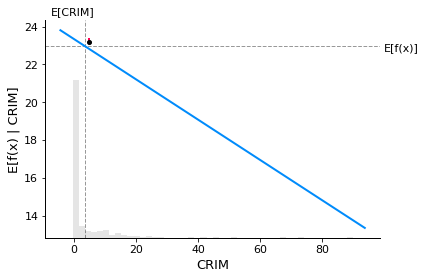

In [21]:
partial_dependence_plot('CRIM', 0)

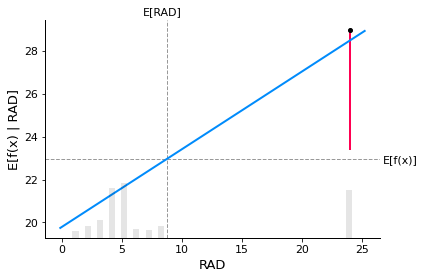

In [22]:
partial_dependence_plot('RAD', 0)

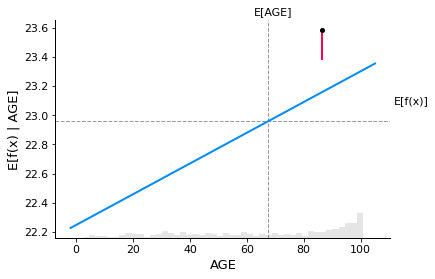

In [23]:
partial_dependence_plot('AGE', 0)

## Shap Plots

Hard to look at every feature for every sample. So lets look at all features of the same sample

In [24]:
shap.initjs()

In [25]:
def sample_feature_importance(idx, type='condensed'):
    if type == 'condensed':
        return shap.plots.force(shap_values[idx])
    elif type == 'waterfall':
        return shap.plots.waterfall(shap_values[idx])
    else:
        return "Return valid visual ('condensed', 'waterfall')"

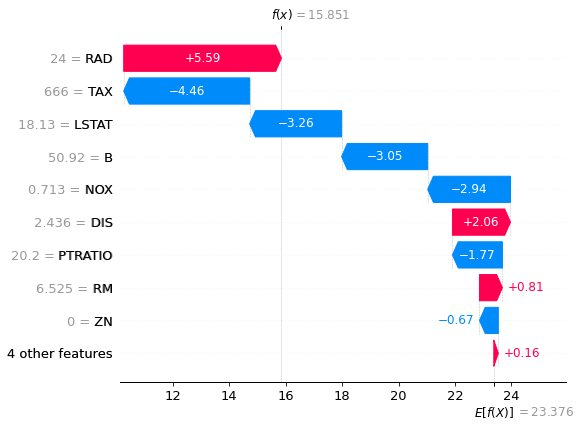

In [26]:
sample_feature_importance(0, 'waterfall')

In [27]:
sample_feature_importance(0, 'condensed')

## Feature Importance for model

Looking at individual samples can be a bother. Let's look at all samples together

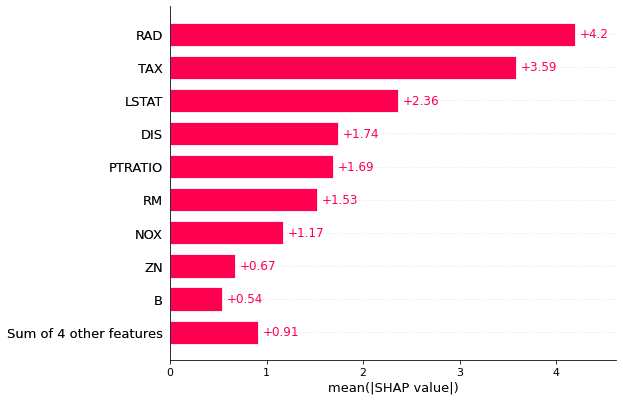

In [28]:
shap.plots.bar(shap_values)

Two most important features according to the LinearRegression model:
- RAD: index of accessibility to radial highways
- TAX: full-value property-tax rate per $10,000

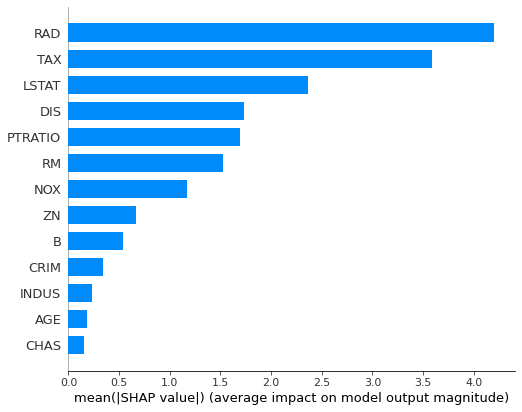

In [29]:
shap.summary_plot(shap_values.values, X_train, plot_type='bar')

We can interpret the neural network model in the same way

In [30]:
preprocessed_X_train = mapper.fit_transform(X_train)

num_epochs = 50
learning_rate = 0.01
hidden_size = 32
batch_size = 50
input_dim = preprocessed_X_train.shape[1]
batch_no = preprocessed_X_train.shape[0] // batch_size
model = nn.Sequential(
    nn.Linear(input_dim, hidden_size),
    nn.Linear(hidden_size, 1)
)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_batch = Variable(torch.FloatTensor(preprocessed_X_train.values[start:end]))
        y_batch = Variable(torch.FloatTensor(y_train[start:end]))
        optimizer.zero_grad()
        y_preds = model(x_batch)
        loss = criterion(y_preds, torch.unsqueeze(y_batch,dim=1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0: 
        print("Epoch {}, Loss: {}".format(epoch, running_loss))
        
preprocessed_X_test = mapper.transform(X_test)
y_pred = model(torch.from_numpy(preprocessed_X_test.values).float()).flatten().detach().numpy()
test_mae = mean_absolute_error(y_test, y_pred)
preprocessed_X_train = mapper.transform(X_train)
y_pred = model(torch.from_numpy(preprocessed_X_train.values).float()).flatten().detach().numpy()
train_mae = mean_absolute_error(y_train, y_pred)
print(f"\ntrain MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

Epoch 0, Loss: 5516.583251953125
Epoch 10, Loss: 305.3524007797241
Epoch 20, Loss: 221.19112873077393
Epoch 30, Loss: 215.44752597808838
Epoch 40, Loss: 213.85873889923096

train MAE = 3.395, test MAE = 2.494 


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


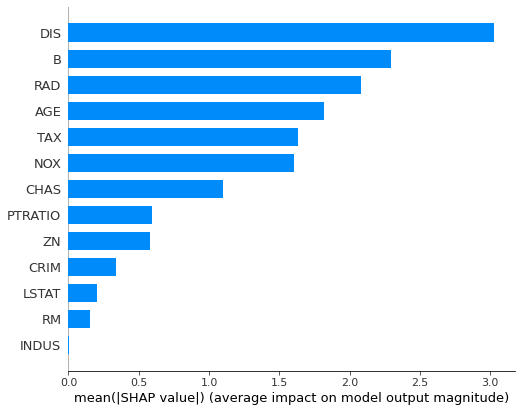

In [31]:
explainer = shap.DeepExplainer(model, torch.from_numpy(preprocessed_X_train.values).float())
shap_values = explainer.shap_values(torch.from_numpy(preprocessed_X_test.values).float())
shap.summary_plot(shap_values, X_test, plot_type='bar')

Most important features for this neural network:
- DIS: weighted distances to five Boston employment centres
- RAD: index of accessibility to radial highways

With this intuition, it's much easier to understand the [math details of Shapely Values](https://christophm.github.io/interpretable-ml-book/shapley.html#the-shapley-value-in-detail).